In [1]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install h5netcdf

Note: you may need to restart the kernel to use updated packages.


In [5]:
import xarray as xr
import numpy as np
import cftime
import matplotlib.pyplot as plt
import jsmetrics
import pandas as pd
import jsmetrics.metrics.jet_statistics as jet_statistics
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    # especificar limites minimos y maximos del grafico
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    # cuadrilla interna del grafico
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    # hacer las etiquetas de ambos ejes mas grandes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(xlab,fontsize=10)
    plt.ylabel(ylab,fontsize=10)
    plt.title(title,fontsize=11)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=8)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [6]:
# Funciòn para mapear contourf con vectores de viento
def contour_f(data,ua,va,levels=np.arange(0,11),ccmap='PuBu',extend='max',limite_NS=42,clevels=np.arange(230,300,15),titulo='OLR y pr',cbarlabel='pr  [mm day$^{-1}$]'):
    lons,lats=data.lon,data.lat
    Lon,Lat=np.meshgrid(ua["lon"],ua["lat"])
    data, lon = add_cyclic_point(data, coord=lons)
    #contourdata, lon = add_cyclic_point(contourdata, coord=lons)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    cs=ax.contourf(lon,lats,data,levels=levels,cmap=ccmap,extend=extend,transform=ccrs.PlateCarree(),alpha=0.9)
    #cc=ax.contour(lon,lats,contourdata,levels=clevels,colors='k',transform=ccrs.PlateCarree())
    #ax.clabel(cc, cc.levels, inline=True, fontsize=10)
    ax.set_extent([-180,180, -limite_NS, limite_NS], crs=ccrs.PlateCarree())
    ax.quiver(Lon[::3,::3],Lat[::3,::3], ua.squeeze()[::3,::3], va.squeeze()[::3,::3], transform=ccrs.PlateCarree(),color="black")
    gl=ax.gridlines(draw_labels=True,color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = True
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    plt.title(titulo,fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.046, pad=0.06)
    cbar.ax.set_xlabel(cbarlabel)

En este notebook se hará el análisis de la temperatura del aire a 200 hPa comparándola con la simulación histórica y del escenario ssp585, al igual que compararla con el viento zonal para las mismas simulaciones

In [7]:
# Leer los archivos de viento 
u_filename='ua_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'
v_filename='va_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'

In [8]:
# Abrir archivos y seleccionar variables a usar 
u_ds=xr.open_dataset(u_filename)
ua=u_ds['ua']  #viento zonal
plevu=u_ds['plev'] #presiones
v_ds=xr.open_dataset(v_filename)
va=v_ds['va']
plevv=v_ds['plev']

In [9]:
#Seleccionar solo 200 hPa y de 1979 a 2014
ua200hPa = ua.sel(plev=20000).where(ua.time.dt.year >= 1979, drop=True)
va200hPa = va.sel(plev=20000).where(va.time.dt.year >= 1979, drop=True)

In [10]:
# Calcular climatología estacional de u,v y seleccionar DJF (invierno) a 200 hPa
ua_estacion200=ua200hPa.groupby(ua200hPa.time.dt.season).mean(dim='time') 
ua_DJF200 = ua_estacion200[0]
va_estacion200=va200hPa.groupby(va200hPa.time.dt.season).mean(dim='time') 
va_DJF200= va_estacion200[0]/100

In [11]:
# Leer archivo ssp585
u_filename585 ='ua_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc'
v_filename585='va_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc'

In [12]:
# Seleccionar variables del archivo ssp585
u_ds585=xr.open_dataset(u_filename585)
ua585=u_ds585['ua']
v_ds585=xr.open_dataset(v_filename585)
va585=v_ds585['va']

In [13]:
#ua_585=ua585.where(ua585.time.dt.year>2069) #solo periodo de 2070 a 2100
#Seleccionar solo el nivel de 200 hPa
ua2070 = ua585.sel(plev=20000).where(ua585.time.dt.year >= 2070, drop=True)
va2070 = va585.sel(plev=20000).where(va585.time.dt.year >= 2070, drop=True)

In [14]:
# Calcular promedio estacional y selecionar DJF a 200 hPa
ua_585_estacion=ua2070.groupby(ua2070.time.dt.season).mean(dim='time') 
ua_585_DJF = ua_585_estacion[0]
va_585_estacion=va2070.groupby(va2070.time.dt.season).mean(dim='time') 
va_585_DJF = va_585_estacion[0]

In [15]:
#Cargando los datos de temperatura a 200 hPa tanto para histórica como para la simulación
tah_filename='ta_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'
ta585_filename='ta_Amon_HadGEM3-GC31-LL_ssp585_r3i1p1f3_gn_205001-210012.nc'

In [16]:
# Seleccionar variables del archivo ssp585
tah=xr.open_dataset(tah_filename)
tah200=tah['ta']
ta585=xr.open_dataset(ta585_filename)
tas200=ta585['ta']

In [17]:
#ua_585=ua585.where(ua585.time.dt.year>2069) #solo periodo de 2070 a 2100
#Seleccionar solo el nivel de 200 hPa
tah1979 = tah200.sel(plev=20000).where(tah200.time.dt.year >= 1979, drop=True)
tas2070 = tas200.sel(plev=20000).where(tas200.time.dt.year >= 2070, drop=True)

In [18]:
# Calcular promedio estacional y selecionar DJF a 200 hPa
tah200_estacion=tah1979.groupby(tah1979.time.dt.season).mean(dim='time') 
tah200_DJF = tah200_estacion[0]
tas200_estacion=tas2070.groupby(tas2070.time.dt.season).mean(dim='time') 
tas200_DJF =tas200_estacion[0]

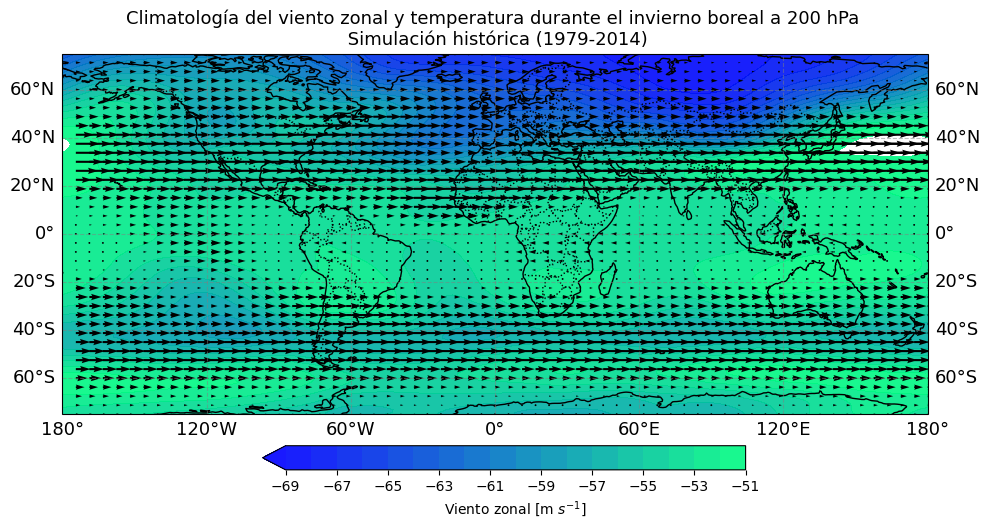

In [40]:
# Mapear la magnitud del viento zonal y temperatura en DJF a 200 hPa
contour_f(tah200_DJF-273.15,ua_DJF200,va_DJF200,levels=np.arange(-69,-50),ccmap='winter',extend='min',limite_NS=75,clevels=np.arange(5,75,15),titulo=
      'Climatología del viento zonal y temperatura a 200 hPa durante el invierno boreal \n Simulación histórica (1979-2014)',cbarlabel='Viento zonal [m $s^{-1}$]')
#plt.savefig('temph_200hPa.png', dpi=300, bbox_inches='tight')

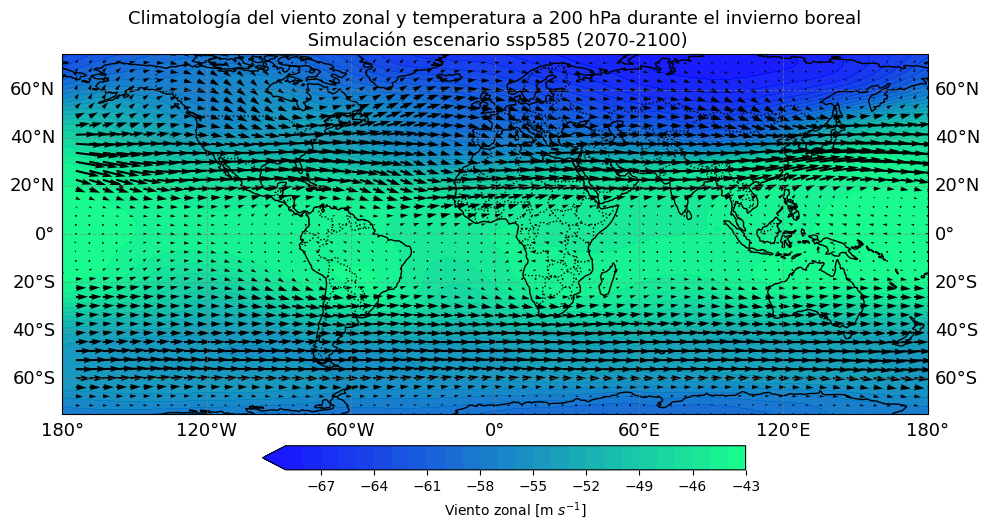

In [49]:
#Climatología de viento zonal y temperatura a 200 hPa simulación ssp585
contour_f(tas200_DJF-273.15,ua_585_DJF,va_585_DJF,levels=np.arange(-69,-42),ccmap='winter',extend='min',limite_NS=75,clevels=np.arange(5,75,15),titulo=
      'Climatología del viento zonal y temperatura a 200 hPa durante el invierno boreal\n Simulación escenario ssp585 (2070-2100)',cbarlabel='Viento zonal [m $s^{-1}$]')
#plt.savefig('ts.png', dpi=300, bbox_inches='tight')